In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE, EI3, GPM
from torch_geometric.utils import k_hop_subgraph

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (27680, 8)


/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


In [3]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

"""EIIE (ensemble of identical independent evaluators) policy network
initializer.
Args:
    initial_features: Number of input features.
    k_size: Size of first convolutional kernel.
    conv_mid_features: Size of intermediate convolutional channels.
    conv_final_features: Size of final convolutional channels.
    time_window: Size of time window used as agent's state.
    device: Device in which the neural network will be run.
Note:
    Reference article: https://doi.org/10.48550/arXiv.1706.10059.
"""
EIIE_model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}
EIIE_policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}
EIIE_model = DRLAgent(environment).get_model("pg", device, EIIE_model_kwargs, EIIE_policy_kwargs)



"""EI3 (ensemble of identical independent inception) policy network
initializer.
Args:
    initial_features: Number of input features.
    k_short: Size of short convolutional kernel.
    k_medium: Size of medium convolutional kernel.
    conv_mid_features: Size of intermediate convolutional channels.
    conv_final_features: Size of final convolutional channels.
    time_window: Size of time window used as agent's state.
    device: Device in which the neural network will be run.
Note:
    Reference article: https://doi.org/10.1145/3357384.3357961.
"""

EI3_model_kwargs = {
    "lr": 0.01,
    "policy": EI3,
}
EI3_policy_kwargs = {
    "k_short": 3,
    "k_medium": 21,
    "time_window": 50,
}
EI3_model = DRLAgent(environment).get_model("pg", device, EI3_model_kwargs, EI3_policy_kwargs)

In [4]:
DRLAgent.train_model(EIIE_model, episodes=40)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 268133.40625
Final accumulative portfolio value: 2.6813340625
Maximum DrawDown: -0.3342094009167563
Sharpe ratio: 0.8226385655388245


  2%|▎         | 1/40 [00:06<04:18,  6.63s/it]

Initial portfolio value:100000
Final portfolio value: 532370.375
Final accumulative portfolio value: 5.32370375
Maximum DrawDown: -0.3434686732555924
Sharpe ratio: 1.066947655125837


  5%|▌         | 2/40 [00:13<04:10,  6.60s/it]

Initial portfolio value:100000
Final portfolio value: 778355.375
Final accumulative portfolio value: 7.78355375
Maximum DrawDown: -0.3262976817562412
Sharpe ratio: 1.164723792724703


  8%|▊         | 3/40 [00:19<04:06,  6.65s/it]

Initial portfolio value:100000
Final portfolio value: 840030.125
Final accumulative portfolio value: 8.40030125
Maximum DrawDown: -0.31398757859963466
Sharpe ratio: 1.1784007328388693


 10%|█         | 4/40 [00:26<03:57,  6.59s/it]

Initial portfolio value:100000
Final portfolio value: 848746.3125
Final accumulative portfolio value: 8.487463125
Maximum DrawDown: -0.31323691005503107
Sharpe ratio: 1.1853853800927423


 12%|█▎        | 5/40 [00:33<03:52,  6.65s/it]

Initial portfolio value:100000
Final portfolio value: 856185.0625
Final accumulative portfolio value: 8.561850625
Maximum DrawDown: -0.31257847843376585
Sharpe ratio: 1.1916886861616534


 15%|█▌        | 6/40 [00:40<03:53,  6.87s/it]

Initial portfolio value:100000
Final portfolio value: 866399.875
Final accumulative portfolio value: 8.66399875
Maximum DrawDown: -0.3119741561325825
Sharpe ratio: 1.1995897817182086


 18%|█▊        | 7/40 [00:47<03:46,  6.87s/it]

Initial portfolio value:100000
Final portfolio value: 879017.5625
Final accumulative portfolio value: 8.790175625
Maximum DrawDown: -0.3115853322887179
Sharpe ratio: 1.209410742134027


 20%|██        | 8/40 [00:53<03:36,  6.76s/it]

Initial portfolio value:100000
Final portfolio value: 893991.4375
Final accumulative portfolio value: 8.939914375
Maximum DrawDown: -0.31135611595620716
Sharpe ratio: 1.2214445268373328


 22%|██▎       | 9/40 [01:00<03:30,  6.80s/it]

Initial portfolio value:100000
Final portfolio value: 911149.3125
Final accumulative portfolio value: 9.111493125
Maximum DrawDown: -0.310750426139656
Sharpe ratio: 1.234418885249512


 25%|██▌       | 10/40 [01:07<03:26,  6.89s/it]

Initial portfolio value:100000
Final portfolio value: 933265.375
Final accumulative portfolio value: 9.33265375
Maximum DrawDown: -0.30995616692465155
Sharpe ratio: 1.2499530577129068


 28%|██▊       | 11/40 [01:14<03:19,  6.89s/it]

Initial portfolio value:100000
Final portfolio value: 961451.625
Final accumulative portfolio value: 9.61451625
Maximum DrawDown: -0.3091036088622714
Sharpe ratio: 1.2683055630728228


 30%|███       | 12/40 [01:21<03:13,  6.91s/it]

Initial portfolio value:100000
Final portfolio value: 997782.875
Final accumulative portfolio value: 9.97782875
Maximum DrawDown: -0.30832651614104434
Sharpe ratio: 1.2897597741971447


 32%|███▎      | 13/40 [01:28<03:03,  6.79s/it]

Initial portfolio value:100000
Final portfolio value: 1036811.625
Final accumulative portfolio value: 10.36811625
Maximum DrawDown: -0.30825218495962525
Sharpe ratio: 1.3121959073164517


 35%|███▌      | 14/40 [01:35<02:56,  6.80s/it]

Initial portfolio value:100000
Final portfolio value: 1089092.25
Final accumulative portfolio value: 10.8909225
Maximum DrawDown: -0.312598006220403
Sharpe ratio: 1.3361743003134958


 38%|███▊      | 15/40 [01:41<02:50,  6.84s/it]

Initial portfolio value:100000
Final portfolio value: 1148835.5
Final accumulative portfolio value: 11.488355
Maximum DrawDown: -0.31802343393904686
Sharpe ratio: 1.360874876184608


 40%|████      | 16/40 [01:48<02:42,  6.77s/it]

Initial portfolio value:100000
Final portfolio value: 1205006.5
Final accumulative portfolio value: 12.050065
Maximum DrawDown: -0.32625122834922027
Sharpe ratio: 1.3768451171907907


 42%|████▎     | 17/40 [01:55<02:35,  6.75s/it]

Initial portfolio value:100000
Final portfolio value: 1260748.75
Final accumulative portfolio value: 12.6074875
Maximum DrawDown: -0.33027566588868973
Sharpe ratio: 1.3993714680311784


 45%|████▌     | 18/40 [02:01<02:27,  6.70s/it]

Initial portfolio value:100000
Final portfolio value: 1223636.625
Final accumulative portfolio value: 12.23636625
Maximum DrawDown: -0.3493198694267887
Sharpe ratio: 1.3497786857628493


 48%|████▊     | 19/40 [02:08<02:19,  6.64s/it]

Initial portfolio value:100000
Final portfolio value: 1268319.75
Final accumulative portfolio value: 12.6831975
Maximum DrawDown: -0.3269829069695076
Sharpe ratio: 1.4064358846223566


 50%|█████     | 20/40 [02:15<02:14,  6.72s/it]

Initial portfolio value:100000
Final portfolio value: 1091510.75
Final accumulative portfolio value: 10.9151075
Maximum DrawDown: -0.3703053166887753
Sharpe ratio: 1.2754655094938634


 52%|█████▎    | 21/40 [02:22<02:08,  6.77s/it]

Initial portfolio value:100000
Final portfolio value: 1231622.25
Final accumulative portfolio value: 12.3162225
Maximum DrawDown: -0.3676278824213889
Sharpe ratio: 1.3215417077318792


 55%|█████▌    | 22/40 [02:28<02:01,  6.74s/it]

Initial portfolio value:100000
Final portfolio value: 1438892.5
Final accumulative portfolio value: 14.388925
Maximum DrawDown: -0.3584024632310794
Sharpe ratio: 1.4121648362040269


 57%|█████▊    | 23/40 [02:35<01:54,  6.76s/it]

Initial portfolio value:100000
Final portfolio value: 1282157.0
Final accumulative portfolio value: 12.82157
Maximum DrawDown: -0.3366867998093638
Sharpe ratio: 1.4029557905575867


 60%|██████    | 24/40 [02:42<01:49,  6.81s/it]

Initial portfolio value:100000
Final portfolio value: 1190244.625
Final accumulative portfolio value: 11.90244625
Maximum DrawDown: -0.37714403096954763
Sharpe ratio: 1.326300527830255


 62%|██████▎   | 25/40 [02:49<01:40,  6.73s/it]

Initial portfolio value:100000
Final portfolio value: 687558.875
Final accumulative portfolio value: 6.87558875
Maximum DrawDown: -0.3403739542221268
Sharpe ratio: 1.2123820983500488


 65%|██████▌   | 26/40 [02:55<01:34,  6.74s/it]

Initial portfolio value:100000
Final portfolio value: 1566882.75
Final accumulative portfolio value: 15.6688275
Maximum DrawDown: -0.3631047462983994
Sharpe ratio: 1.4645888528657065


 68%|██████▊   | 27/40 [03:02<01:27,  6.71s/it]

Initial portfolio value:100000
Final portfolio value: 1386147.5
Final accumulative portfolio value: 13.861475
Maximum DrawDown: -0.36771485695319195
Sharpe ratio: 1.3836286177368677


 70%|███████   | 28/40 [03:08<01:19,  6.64s/it]

Initial portfolio value:100000
Final portfolio value: 1343839.125
Final accumulative portfolio value: 13.43839125
Maximum DrawDown: -0.3535527706699886
Sharpe ratio: 1.418051551481072


 72%|███████▎  | 29/40 [03:15<01:12,  6.60s/it]

Initial portfolio value:100000
Final portfolio value: 1183729.5
Final accumulative portfolio value: 11.837295
Maximum DrawDown: -0.3765170928002304
Sharpe ratio: 1.294095835572581


 75%|███████▌  | 30/40 [03:22<01:05,  6.59s/it]

Initial portfolio value:100000
Final portfolio value: 1396540.25
Final accumulative portfolio value: 13.9654025
Maximum DrawDown: -0.3744226123662755
Sharpe ratio: 1.369541389247434


 78%|███████▊  | 31/40 [03:28<00:59,  6.64s/it]

Initial portfolio value:100000
Final portfolio value: 1457452.125
Final accumulative portfolio value: 14.57452125
Maximum DrawDown: -0.36338040335922206
Sharpe ratio: 1.4375522545234711


 80%|████████  | 32/40 [03:35<00:53,  6.63s/it]

Initial portfolio value:100000
Final portfolio value: 1317523.25
Final accumulative portfolio value: 13.1752325
Maximum DrawDown: -0.3752094475106229
Sharpe ratio: 1.345112369050732


 82%|████████▎ | 33/40 [03:42<00:46,  6.71s/it]

Initial portfolio value:100000
Final portfolio value: 1485963.0
Final accumulative portfolio value: 14.85963
Maximum DrawDown: -0.36957939390334316
Sharpe ratio: 1.415941241128258


 85%|████████▌ | 34/40 [03:49<00:40,  6.76s/it]

Initial portfolio value:100000
Final portfolio value: 1295536.5
Final accumulative portfolio value: 12.955365
Maximum DrawDown: -0.376556259188231
Sharpe ratio: 1.333391578969555


 88%|████████▊ | 35/40 [03:55<00:33,  6.71s/it]

Initial portfolio value:100000
Final portfolio value: 1492305.25
Final accumulative portfolio value: 14.9230525
Maximum DrawDown: -0.36968459887101757
Sharpe ratio: 1.4175473860758363


 90%|█████████ | 36/40 [04:02<00:26,  6.65s/it]

Initial portfolio value:100000
Final portfolio value: 1323468.125
Final accumulative portfolio value: 13.23468125
Maximum DrawDown: -0.3761179712422893
Sharpe ratio: 1.3438505287247933


 92%|█████████▎| 37/40 [04:09<00:20,  6.85s/it]

Initial portfolio value:100000
Final portfolio value: 1509831.75
Final accumulative portfolio value: 15.0983175
Maximum DrawDown: -0.3704475987679542
Sharpe ratio: 1.4146156863768355


 95%|█████████▌| 38/40 [04:16<00:13,  6.90s/it]

Initial portfolio value:100000
Final portfolio value: 1324264.125
Final accumulative portfolio value: 13.24264125
Maximum DrawDown: -0.376451497150711
Sharpe ratio: 1.3433729262980891


 98%|█████████▊| 39/40 [04:23<00:06,  6.81s/it]

Initial portfolio value:100000
Final portfolio value: 1520418.125
Final accumulative portfolio value: 15.20418125
Maximum DrawDown: -0.3709547270721628
Sharpe ratio: 1.4145520070858484


100%|██████████| 40/40 [04:29<00:00,  6.75s/it]


In [12]:
environment.reset()
DRLAgent.train_model(EI3_model, episodes=40)
torch.save(EI3_model.train_policy.state_dict(), "policy_EI3.pt")

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 315260.9375
Final accumulative portfolio value: 3.152609375
Maximum DrawDown: -0.3445222140195028
Sharpe ratio: 0.907166881746057


  2%|▎         | 1/40 [00:06<04:26,  6.83s/it]

Initial portfolio value:100000
Final portfolio value: 713771.25
Final accumulative portfolio value: 7.1377125
Maximum DrawDown: -0.2762503224487268
Sharpe ratio: 1.2982818563143357


  5%|▌         | 2/40 [00:13<04:13,  6.67s/it]

Initial portfolio value:100000
Final portfolio value: 842076.75
Final accumulative portfolio value: 8.4207675
Maximum DrawDown: -0.32888935890358106
Sharpe ratio: 1.2082658662859247


  8%|▊         | 3/40 [00:19<04:03,  6.59s/it]

Initial portfolio value:100000
Final portfolio value: 839858.875
Final accumulative portfolio value: 8.39858875
Maximum DrawDown: -0.3144655129309676
Sharpe ratio: 1.186393013322557


 10%|█         | 4/40 [00:26<03:54,  6.53s/it]

Initial portfolio value:100000
Final portfolio value: 868874.375
Final accumulative portfolio value: 8.68874375
Maximum DrawDown: -0.31291655798324636
Sharpe ratio: 1.2005147095124347


 12%|█▎        | 5/40 [00:32<03:46,  6.48s/it]

Initial portfolio value:100000
Final portfolio value: 887945.0625
Final accumulative portfolio value: 8.879450625
Maximum DrawDown: -0.31251781730292516
Sharpe ratio: 1.2152785107485244


 15%|█▌        | 6/40 [00:39<03:44,  6.60s/it]

Initial portfolio value:100000
Final portfolio value: 906490.125
Final accumulative portfolio value: 9.06490125
Maximum DrawDown: -0.312271861315671
Sharpe ratio: 1.2296130970786263


 18%|█▊        | 7/40 [00:45<03:36,  6.55s/it]

Initial portfolio value:100000
Final portfolio value: 926961.8125
Final accumulative portfolio value: 9.269618125
Maximum DrawDown: -0.31155746250733163
Sharpe ratio: 1.2448156638840862


 20%|██        | 8/40 [00:52<03:28,  6.52s/it]

Initial portfolio value:100000
Final portfolio value: 952406.25
Final accumulative portfolio value: 9.5240625
Maximum DrawDown: -0.3107366596411054
Sharpe ratio: 1.262231397189525


 22%|██▎       | 9/40 [00:59<03:22,  6.55s/it]

Initial portfolio value:100000
Final portfolio value: 984820.25
Final accumulative portfolio value: 9.8482025
Maximum DrawDown: -0.309930253599527
Sharpe ratio: 1.2824840334824146


 25%|██▌       | 10/40 [01:05<03:15,  6.52s/it]

Initial portfolio value:100000
Final portfolio value: 1025918.1875
Final accumulative portfolio value: 10.259181875
Maximum DrawDown: -0.30929396659326935
Sharpe ratio: 1.3058548666980598


 28%|██▊       | 11/40 [01:11<03:08,  6.49s/it]

Initial portfolio value:100000
Final portfolio value: 1076495.0
Final accumulative portfolio value: 10.76495
Maximum DrawDown: -0.31174194542119915
Sharpe ratio: 1.331276371592175


 30%|███       | 12/40 [01:18<03:01,  6.47s/it]

Initial portfolio value:100000
Final portfolio value: 1135299.625
Final accumulative portfolio value: 11.35299625
Maximum DrawDown: -0.3169793939275729
Sharpe ratio: 1.3565194279690944


 32%|███▎      | 13/40 [01:24<02:54,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 1197045.25
Final accumulative portfolio value: 11.9704525
Maximum DrawDown: -0.32415418886835856
Sharpe ratio: 1.3782597357925581


 35%|███▌      | 14/40 [01:31<02:47,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 1254932.0
Final accumulative portfolio value: 12.54932
Maximum DrawDown: -0.3320834738697567
Sharpe ratio: 1.3947687923757328


 38%|███▊      | 15/40 [01:37<02:42,  6.48s/it]

Initial portfolio value:100000
Final portfolio value: 1303985.625
Final accumulative portfolio value: 13.03985625
Maximum DrawDown: -0.3402358021337347
Sharpe ratio: 1.4043954946652977


 40%|████      | 16/40 [01:44<02:35,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 1346276.375
Final accumulative portfolio value: 13.46276375
Maximum DrawDown: -0.345755656095489
Sharpe ratio: 1.4137891210654807


 42%|████▎     | 17/40 [01:50<02:28,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 1338327.875
Final accumulative portfolio value: 13.38327875
Maximum DrawDown: -0.3568603732901846
Sharpe ratio: 1.388366765142858


 45%|████▌     | 18/40 [01:57<02:21,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 250885.09375
Final accumulative portfolio value: 2.5088509375
Maximum DrawDown: -0.3200528815333562
Sharpe ratio: 0.6684743235127842


 48%|████▊     | 19/40 [02:03<02:15,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 188766.65625
Final accumulative portfolio value: 1.8876665625
Maximum DrawDown: -0.3012599439449547
Sharpe ratio: 0.49929107093500663


 50%|█████     | 20/40 [02:09<02:08,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 188949.4375
Final accumulative portfolio value: 1.889494375
Maximum DrawDown: -0.30125981865175033
Sharpe ratio: 0.49967202814910877


 52%|█████▎    | 21/40 [02:16<02:02,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188971.15625
Final accumulative portfolio value: 1.8897115625
Maximum DrawDown: -0.30125984450527044
Sharpe ratio: 0.4997110438126139


 55%|█████▌    | 22/40 [02:22<01:55,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188981.6875
Final accumulative portfolio value: 1.889816875
Maximum DrawDown: -0.3012597022254575
Sharpe ratio: 0.49972961518889164


 57%|█████▊    | 23/40 [02:29<01:49,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188989.40625
Final accumulative portfolio value: 1.8898940625
Maximum DrawDown: -0.30125997458666975
Sharpe ratio: 0.49974142854609804


 60%|██████    | 24/40 [02:35<01:42,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188996.015625
Final accumulative portfolio value: 1.88996015625
Maximum DrawDown: -0.30125993182127286
Sharpe ratio: 0.4997546515841505


 62%|██████▎   | 25/40 [02:42<01:36,  6.47s/it]

Initial portfolio value:100000
Final portfolio value: 189001.921875
Final accumulative portfolio value: 1.89001921875
Maximum DrawDown: -0.30125963514824505
Sharpe ratio: 0.49976578246479125


 65%|██████▌   | 26/40 [02:48<01:30,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 189006.796875
Final accumulative portfolio value: 1.89006796875
Maximum DrawDown: -0.30125995691133056
Sharpe ratio: 0.49977276914069135


 68%|██████▊   | 27/40 [02:55<01:23,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 189010.625
Final accumulative portfolio value: 1.89010625
Maximum DrawDown: -0.3012603997300731
Sharpe ratio: 0.49977740479293825


 70%|███████   | 28/40 [03:01<01:17,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 189015.09375
Final accumulative portfolio value: 1.8901509375
Maximum DrawDown: -0.30125971598049306
Sharpe ratio: 0.49978633072753464


 72%|███████▎  | 29/40 [03:07<01:10,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 189019.921875
Final accumulative portfolio value: 1.89019921875
Maximum DrawDown: -0.3012590809479133
Sharpe ratio: 0.49979388355620985


 75%|███████▌  | 30/40 [03:14<01:04,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 189023.25
Final accumulative portfolio value: 1.8902325
Maximum DrawDown: -0.3012590984581607
Sharpe ratio: 0.4997986463526372


 78%|███████▊  | 31/40 [03:20<00:57,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189025.484375
Final accumulative portfolio value: 1.89025484375
Maximum DrawDown: -0.3012592779331843
Sharpe ratio: 0.4998000694912254


 80%|████████  | 32/40 [03:27<00:51,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189028.296875
Final accumulative portfolio value: 1.89028296875
Maximum DrawDown: -0.30125945231592044
Sharpe ratio: 0.49980560829925064


 82%|████████▎ | 33/40 [03:33<00:44,  6.41s/it]

Initial portfolio value:100000
Final portfolio value: 189029.6875
Final accumulative portfolio value: 1.890296875
Maximum DrawDown: -0.3012593302425095
Sharpe ratio: 0.49980699844150256


 85%|████████▌ | 34/40 [03:39<00:38,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189032.40625
Final accumulative portfolio value: 1.8903240625
Maximum DrawDown: -0.3012596594589515
Sharpe ratio: 0.49981245413923636


 88%|████████▊ | 35/40 [03:46<00:32,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189033.453125
Final accumulative portfolio value: 1.89033453125
Maximum DrawDown: -0.30125939439411087
Sharpe ratio: 0.4998120965167633


 90%|█████████ | 36/40 [03:52<00:25,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189035.140625
Final accumulative portfolio value: 1.89035140625
Maximum DrawDown: -0.3012587865274283
Sharpe ratio: 0.4998123994114851


 92%|█████████▎| 37/40 [03:59<00:19,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189037.171875
Final accumulative portfolio value: 1.89037171875
Maximum DrawDown: -0.3012593223098362
Sharpe ratio: 0.4998150044141911


 95%|█████████▌| 38/40 [04:05<00:12,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 189036.984375
Final accumulative portfolio value: 1.89036984375
Maximum DrawDown: -0.30125987806974797
Sharpe ratio: 0.49981402294026667


 98%|█████████▊| 39/40 [04:12<00:06,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 189039.09375
Final accumulative portfolio value: 1.8903909375
Maximum DrawDown: -0.30125933342296174
Sharpe ratio: 0.49981587817945405


100%|██████████| 40/40 [04:18<00:00,  6.47s/it]


GPM

In [ ]:

"""GPM (Graph-based Portfolio Management) policy network initializer.
Args:
    edge_index: Graph connectivity in COO format.
    edge_type: Type of each edge in edge_index.
    nodes_to_select: ID of nodes to be selected to the portfolio.
    initial_features: Number of input features.
    k_short: Size of short convolutional kernel.
    k_medium: Size of medium convolutional kernel.
    conv_mid_features: Size of intermediate convolutional channels.
    conv_final_features: Size of final convolutional channels.
    graph_layers: Number of graph neural network layers.
    time_window: Size of time window used as agent's state.
    softmax_temperature: Temperature parameter to softmax function.
    device: Device in which the neural network will be run.
Note:
    Reference articles:
    Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.
    GPM Demo: https://cocalc.com/github/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_GPM_Demo.ipynb
    Temporal Relational Ranking: https://arxiv.org/pdf/1809.09441
    temporal relational ranking data: https://github.com/CaioSBC/Temporal_Relational_Stock_Ranking_FinRL 

"""
# GPM_model_kwargs = {
#     "lr": 0.01,
#     "policy": GPM,
# }
# GPM_policy_kwargs = {
#     "edge_index": ,
#     "edge_type": ,
#     "nodes_to_select": ,
# }
# GPM_model = DRLAgent(environment).get_model("pg", device, GPM_model_kwargs, GPM_policy_kwargs)
# DRLAgent.train_model(GPM_model, episodes=40)
# torch.save(GPM_model.train_policy.state_dict(), "policy_GPM.pt")

Evaluation

In [4]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
EI3_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
EIIE_policy = EIIE(time_window=50, device=device)
EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))

environment.reset()
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]

EI3_policy = EI3(time_window=50, device=device)
EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

environment.reset()
DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
EI3_results["train"]["value"] = environment._asset_memory["final"]
environment_2021.reset()
DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
environment_2022.reset()
DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
environment_2023.reset()
DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28521/1468981087.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("poli

Initial portfolio value:100000
Final portfolio value: 1026004.625
Final accumulative portfolio value: 10.26004625
Maximum DrawDown: -0.38277245826462536
Sharpe ratio: 1.2268727976903766
Initial portfolio value:100000
Final portfolio value: 105869.3046875
Final accumulative portfolio value: 1.058693046875
Maximum DrawDown: -0.15499429998014524
Sharpe ratio: 0.4200912175229763
Initial portfolio value:100000
Final portfolio value: 116650.6953125
Final accumulative portfolio value: 1.166506953125
Maximum DrawDown: -0.1078101123998495
Sharpe ratio: 0.9466021224108623
Initial portfolio value:100000
Final portfolio value: 101604.90625
Final accumulative portfolio value: 1.0160490625
Maximum DrawDown: -0.15245759616433352
Sharpe ratio: 0.215454314221465


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_28521/1468981087.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EI3_policy.load_state_dict(torch.load("polic

Initial portfolio value:100000
Final portfolio value: 188707.734375
Final accumulative portfolio value: 1.88707734375
Maximum DrawDown: -0.3012597795416153
Sharpe ratio: 0.49887579873457205
Initial portfolio value:100000
Final portfolio value: 91501.859375
Final accumulative portfolio value: 0.91501859375
Maximum DrawDown: -0.19435041737931757
Sharpe ratio: -0.5427966496585976
Initial portfolio value:100000
Final portfolio value: 105109.5859375
Final accumulative portfolio value: 1.051095859375
Maximum DrawDown: -0.13601948753283732
Sharpe ratio: 0.45772585257962584
Initial portfolio value:100000
Final portfolio value: 101425.3828125
Final accumulative portfolio value: 1.014253828125
Maximum DrawDown: -0.11418848716922048
Sharpe ratio: 0.19393202372634552
Initial portfolio value:100000
Final portfolio value: 259607.71875
Final accumulative portfolio value: 2.5960771875
Maximum DrawDown: -0.3467879505313781
Sharpe ratio: 0.782784012646321
Initial portfolio value:100000
Final portfolio v

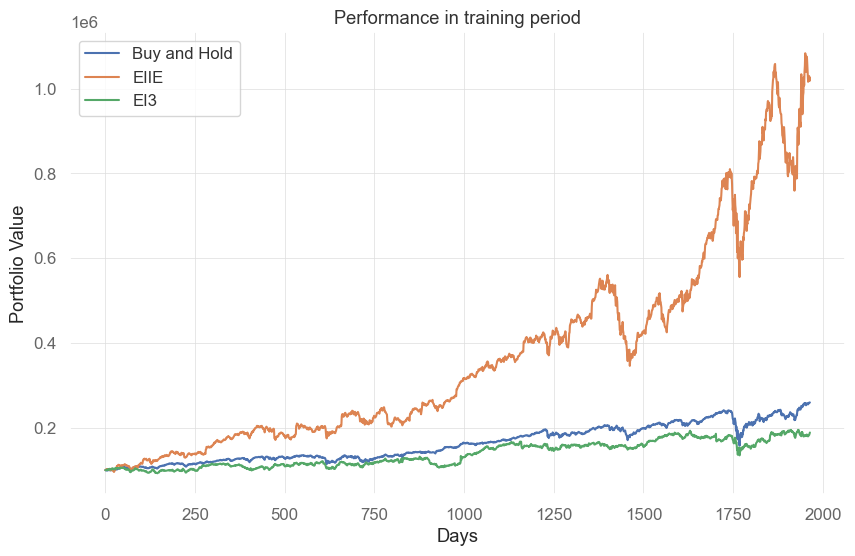

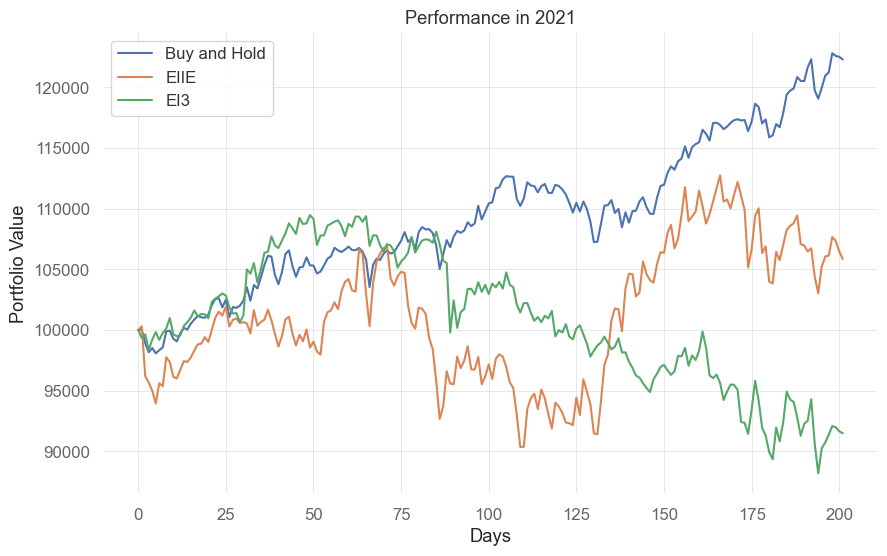

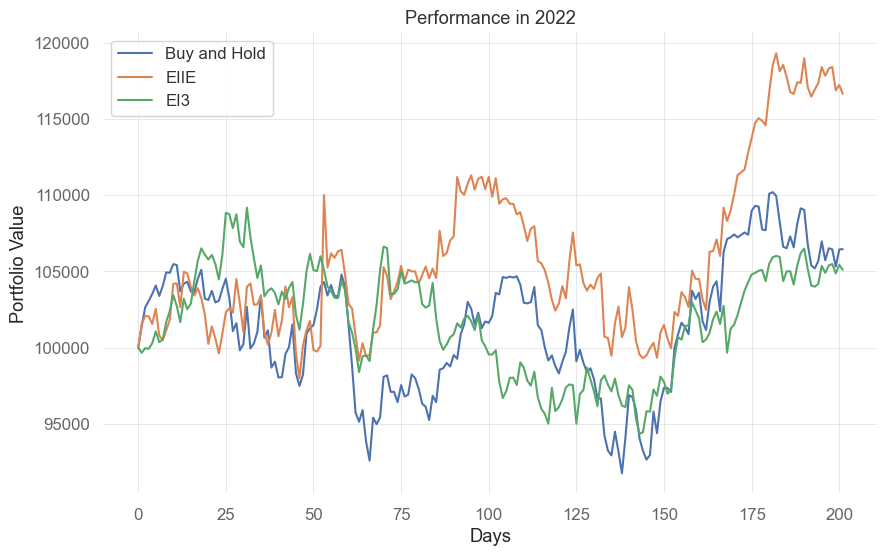

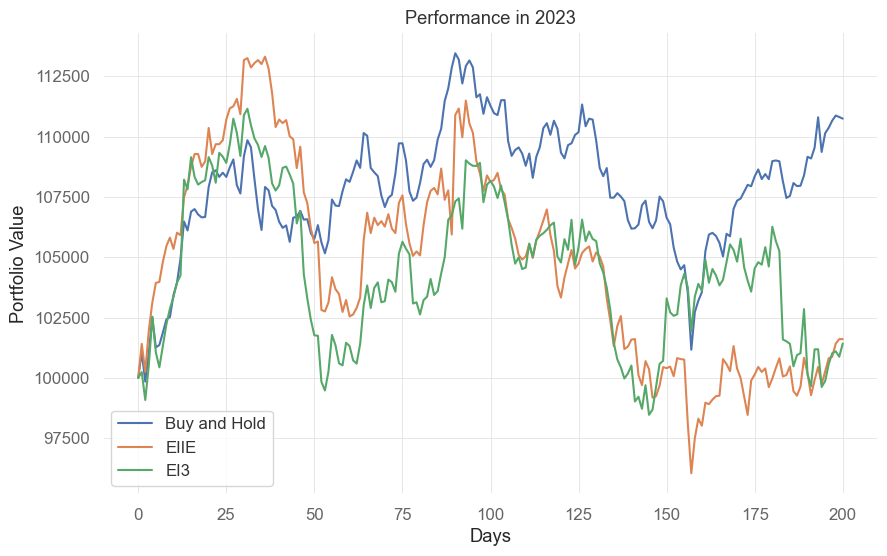

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()